### Load an image and pass it to a model

In [1]:
from skimage import io, img_as_float, img_as_ubyte
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from glob import glob

In [31]:
#img = img_as_float(io.imread('dataset/DIC-HeLa/training/images/t000.tif'))
mask = img_as_float(io.imread('D:/pytorch/data/2D_Zebrafish/labels/embryo1_001_annotationLabels.png'))

In [33]:
mask.shape

(512, 512, 4)

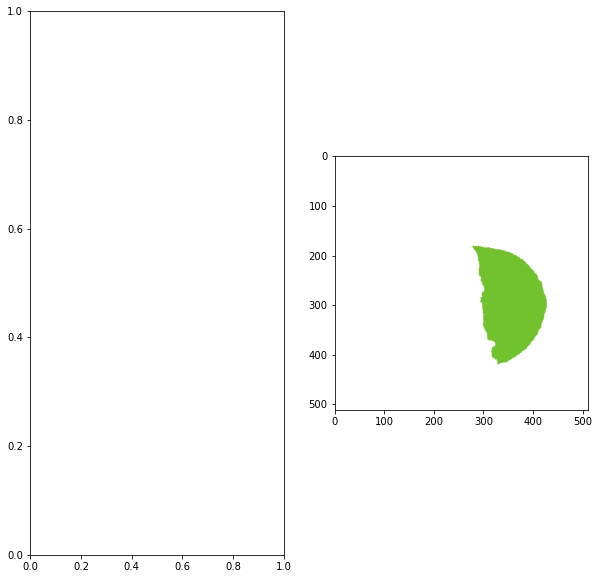

In [32]:
fix, ax = plt.subplots(1, 2, figsize=(10, 10))
#ax[0].imshow(img)
ax[1].imshow(mask)

In [34]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8, pretrained=False)

Using cache found in C:\Users\MichaelSNelson/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [35]:
model.to('cuda')

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_run

In [4]:
input = torch.from_numpy( img )[None, None, :].float()
input = input.to('cuda')
output = model(input)

NameError: name 'img' is not defined

In [36]:
model.train()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # 0.0001

In [41]:
imgs = glob('D:/pytorch/data/2D_Zebrafish/images/*.tif')
masks = glob('D:/pytorch/data/2D_Zebrafish/labels/*.tif')
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = img_as_float(io.imread(img))
    mask = img_as_float(io.imread(mask))
    mask[mask>0] = 1
    input = torch.from_numpy( img )[None, None, :].float().cuda()
    target = torch.from_numpy( mask )[None, None, :].float().cuda()
    output = model(input)
    loss = loss_fn(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss, current = loss.item(), i
    print(f"loss: {loss:>7f}  [{current:>5d}/{len(imgs):>5d}]")

loss: 0.876348  [    0/  160]
loss: 0.859429  [    1/  160]
loss: 0.833134  [    2/  160]
loss: 0.816083  [    3/  160]
loss: 0.813896  [    4/  160]
loss: 0.812618  [    5/  160]
loss: 0.811321  [    6/  160]
loss: 0.810300  [    7/  160]
loss: 0.807953  [    8/  160]
loss: 0.805753  [    9/  160]
loss: 0.791528  [   10/  160]
loss: 0.767661  [   11/  160]
loss: 0.757942  [   12/  160]
loss: 0.777062  [   13/  160]
loss: 0.793060  [   14/  160]
loss: 0.752270  [   15/  160]
loss: 0.879506  [   16/  160]
loss: 0.846663  [   17/  160]
loss: 0.863814  [   18/  160]
loss: 0.827452  [   19/  160]
loss: 0.814280  [   20/  160]
loss: 0.806886  [   21/  160]
loss: 0.801241  [   22/  160]
loss: 0.797506  [   23/  160]
loss: 0.798154  [   24/  160]
loss: 0.782531  [   25/  160]
loss: 0.770491  [   26/  160]
loss: 0.775648  [   27/  160]
loss: 0.768790  [   28/  160]
loss: 0.766306  [   29/  160]
loss: 0.801423  [   30/  160]
loss: 0.728325  [   31/  160]
loss: 0.878907  [   32/  160]
loss: 0.85

### use dataloader

In [42]:
device = 'cuda'
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) # N x 1 x H x W
            test_loss += loss_fn(pred, y).item()
            pred[pred>0.5] = 1
            pred[pred<=0.5] = 0
            correct += (pred == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size*(512**2)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [43]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

In [44]:
class ImageMaskPair(Dataset):
    def __init__(self, img_paths, mask_paths, transforms=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        if transforms is not None:
            self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = img_as_float(io.imread(self.img_paths[idx]))
        mask = img_as_float(io.imread(self.mask_paths[idx]))
        mask[mask>0] = 1
        # img = torch.from_numpy( img )[None, :].float() # C x H x W
        # mask = torch.from_numpy( mask )[None, :].float() # C x H x W
        img = self.transforms(img)
        mask = self.transforms(mask)
        return img, mask

In [45]:
pair_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

In [49]:
img_train_paths = glob('D:/pytorch/data/2D_Zebrafish/images/*.tif')
mask_train_paths = glob('D:/pytorch/data/2D_Zebrafish/labels/*.tif')
img_test_paths = glob('D:/pytorch/data/2D_Zebrafish/testimages/*.tif')
mask_test_paths = glob('D:/pytorch/data/2D_Zebrafish/testlabels/*.tif')

In [50]:
image_mask_train_pair = ImageMaskPair(img_train_paths, mask_train_paths, transforms=pair_transforms)
train_dataloader = DataLoader(image_mask_train_pair, batch_size=4, shuffle=True)
image_mask_test_pair = ImageMaskPair(img_test_paths, mask_test_paths, transforms=pair_transforms)
test_dataloader = DataLoader(image_mask_test_pair, batch_size=4, shuffle=True)

In [51]:
mask_train_paths

['D:/pytorch/data/2D_Zebrafish/labels\\embryo10_001_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_002_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_003_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_004_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_005_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_006_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_007_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_008_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_009_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_010_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_011_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_012_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebrafish/labels\\embryo10_013_annotationLabels.tif',
 'D:/pytorch/data/2D_Zebr

In [52]:
train_images, train_masks = next(iter(test_dataloader))

Feature batch shape: torch.Size([4, 1, 512, 512])
Labels batch shape: torch.Size([4, 1, 512, 512])


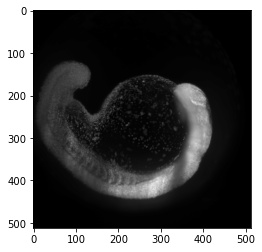

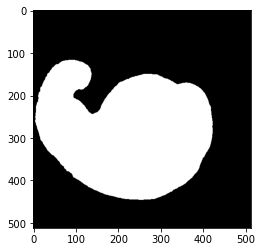

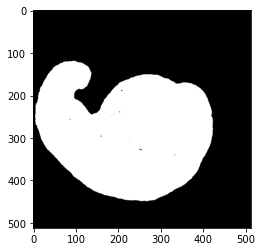

In [59]:
train_images, train_masks = next(iter(test_dataloader))
out_masks = model(train_images.cuda())
print(f"Feature batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_masks.size()}")
img = train_images[0].squeeze()
label = train_masks[0].squeeze()
out_masks[out_masks>0.5] = 1
out_masks[out_masks<=0.5] = 0
out = out_masks[0].detach().cpu().squeeze()
plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()
plt.imshow(out, cmap="gray")
plt.show()

In [58]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) # 0.0001
epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.614544  [    0/  160]
loss: 0.581195  [   40/  160]
loss: 0.585850  [   80/  160]
loss: 0.595710  [  120/  160]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.601114 

Epoch 2
-------------------------------
loss: 0.588135  [    0/  160]
loss: 0.600000  [   40/  160]
loss: 0.588254  [   80/  160]
loss: 0.593363  [  120/  160]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.601111 

Epoch 3
-------------------------------
loss: 0.627296  [    0/  160]
loss: 0.620932  [   40/  160]
loss: 0.594143  [   80/  160]
loss: 0.597096  [  120/  160]


KeyboardInterrupt: 